## Project: Supply Chain Analytics, Forecasting & Root Cause Analysis

#####  Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

##### Load and Inspect Dataset

In [5]:
# Load the dataset
df = pd.read_csv(r'C:\Users\jhanvi.kasundra\Downloads\Schindler project\Data\Train.csv')

# Preview the first 5 rows
print("First 5 rows:\n", df.head())

# Check for missing values
print("\nMissing values:\n", df.isnull().sum())

First 5 rows:
    ID Warehouse_block Mode_of_Shipment  Customer_care_calls  Customer_rating  \
0   1               D           Flight                    4                2   
1   2               F           Flight                    4                5   
2   3               A           Flight                    2                2   
3   4               B           Flight                    3                3   
4   5               C           Flight                    2                2   

   Cost_of_the_Product  Prior_purchases Product_importance Gender  \
0                  177                3                low      F   
1                  216                2                low      M   
2                  183                4                low      M   
3                  176                4             medium      M   
4                  184                3             medium      F   

   Discount_offered  Weight_in_gms  Reached.on.Time_Y.N  
0                44           1

##### Clean and Prepare Data

In [7]:
# Rename confusing column name
df.rename(columns={'Reached.on.Time_Y.N': 'Reached_On_Time'}, inplace=True)


In [8]:

# Convert categorical columns
cat_cols = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']
df[cat_cols] = df[cat_cols].astype('category')


In [9]:

# Create a new binary column: 1 = Late delivery, 0 = On time
df['Late_Delivery'] = df['Reached_On_Time'].apply(lambda x: 0 if x == 1 else 1)


In [13]:

# Simulate demand = Cost × Prior Purchases
df['Simulated_Demand'] = df['Cost_of_the_Product'] * df['Prior_purchases']


In [17]:

# Create a demand category based on cost
df['Demand_Category'] = pd.cut(df['Cost_of_the_Product'], bins=[0, 100, 200, 300], labels=['Low', 'Medium', 'High'])


In [19]:

# Print the updated dataset structure
print("\nUpdated DataFrame:\n", df.dtypes)



Updated DataFrame:
 ID                        int64
Warehouse_block        category
Mode_of_Shipment       category
Customer_care_calls       int64
Customer_rating           int64
Cost_of_the_Product       int64
Prior_purchases           int64
Product_importance     category
Gender                 category
Discount_offered          int64
Weight_in_gms             int64
Reached_On_Time           int64
Late_Delivery             int64
Simulated_Demand          int64
Demand_Category        category
dtype: object


##### Root Cause Analysis – Visualize Delays


Late Deliveries by Warehouse:
 Warehouse_block
A    0.413530
C    0.403164
D    0.402399
F    0.401528
B    0.397709
Name: Late_Delivery, dtype: float64

Late Deliveries by Shipment Mode:
 Mode_of_Shipment
Road      0.411932
Ship      0.402439
Flight    0.398424
Name: Late_Delivery, dtype: float64

Late Deliveries by Product Importance:
 Product_importance
medium    0.409550
low       0.407212
high      0.350211
Name: Late_Delivery, dtype: float64


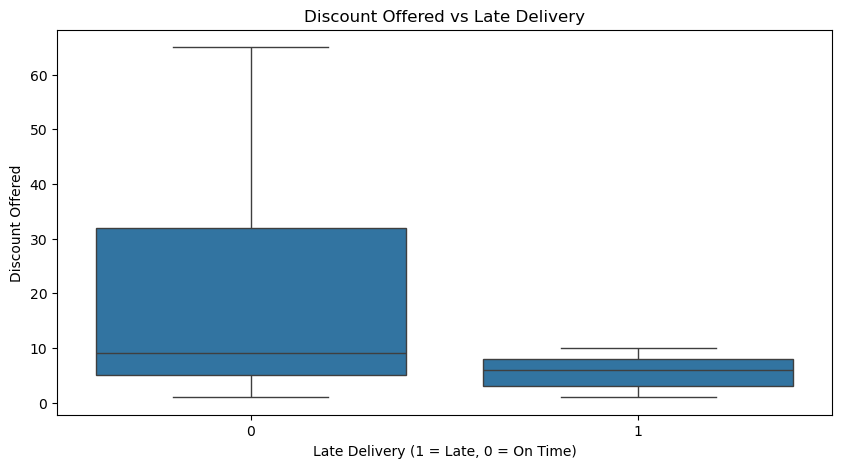

In [22]:
# Late delivery by Warehouse
late_by_warehouse = df.groupby('Warehouse_block')['Late_Delivery'].mean().sort_values(ascending=False)
print("\nLate Deliveries by Warehouse:\n", late_by_warehouse)

# Late delivery by Shipment Mode
late_by_mode = df.groupby('Mode_of_Shipment')['Late_Delivery'].mean().sort_values(ascending=False)
print("\nLate Deliveries by Shipment Mode:\n", late_by_mode)

# Late delivery by Product Importance
late_by_importance = df.groupby('Product_importance')['Late_Delivery'].mean().sort_values(ascending=False)
print("\nLate Deliveries by Product Importance:\n", late_by_importance)

# Visualize Discount vs Late Delivery
plt.figure(figsize=(10, 5))
sns.boxplot(x='Late_Delivery', y='Discount_offered', data=df)
plt.title("Discount Offered vs Late Delivery")
plt.xlabel("Late Delivery (1 = Late, 0 = On Time)")
plt.ylabel("Discount Offered")
plt.show()


##### Simulated Demand Forecasting

In [25]:
# Simulate weekly order grouping (no date column exists, so use ID proxy)
df['Order_Week'] = df['ID'] // 7  # Assume each ID is a new order

# Aggregate demand weekly
weekly_demand = df.groupby('Order_Week')['Simulated_Demand'].sum()

# Split into training and test sets (last 10 weeks as test)
train_data = weekly_demand[:-10]
test_data = weekly_demand[-10:]

# Apply Holt-Winters model for forecasting
model = ExponentialSmoothing(train_data, trend='add', seasonal=None, initialization_method="estimated")
fit = model.fit()
forecast = fit.forecast(10)


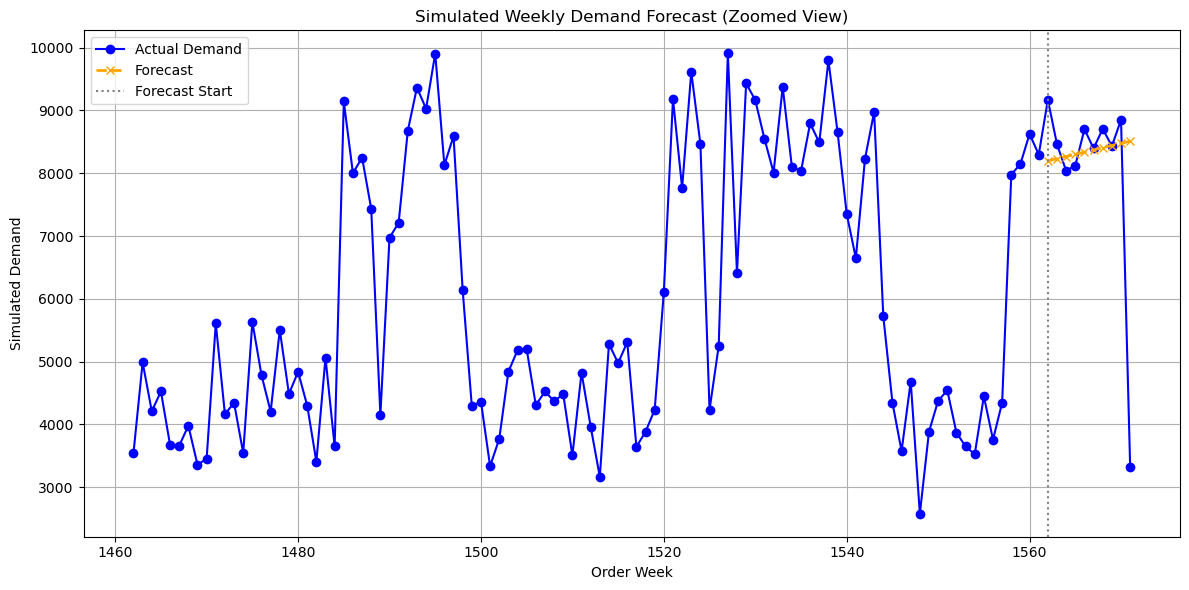

In [27]:
import matplotlib.pyplot as plt

# Step 1: Set up the figure size
plt.figure(figsize=(12, 6))

# Step 2: Define the zoom window (last 100 actual weeks + 10 forecast weeks)
zoom_start = weekly_demand.index[-110]  # Shows last 110 points (100 train + 10 test)

# Step 3: Plot actual demand in blue with circle markers
plt.plot(weekly_demand.loc[zoom_start:].index, 
         weekly_demand.loc[zoom_start:].values, 
         label='Actual Demand', 
         color='blue', 
         marker='o')

# Step 4: Plot forecasted demand in orange with dashed line and 'x' markers
plt.plot(test_data.index, forecast, 
         label='Forecast', 
         color='orange', 
         linestyle='--', 
         marker='x', 
         linewidth=2)

# Step 5: Add vertical line where forecast starts
plt.axvline(x=test_data.index[0], 
            color='gray', 
            linestyle=':', 
            label='Forecast Start')

# Step 6: Add titles and labels
plt.title("Simulated Weekly Demand Forecast (Zoomed View)")
plt.xlabel("Order Week")
plt.ylabel("Simulated Demand")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Step 7: Show the plot
plt.show()


In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate errors
mae = mean_absolute_error(test_data, forecast)
rmse = np.sqrt(mean_squared_error(test_data, forecast))

# Print them
print(f"MAE (Mean Absolute Error): {mae:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")

MAE (Mean Absolute Error): 786.95
RMSE (Root Mean Squared Error): 1684.20


##### Build a Better Forecasting Model (High Accuracy, Low Error)

###### Create a Feature Matrix

In [33]:
# Define features to use for prediction
features = [
    'Warehouse_block',
    'Mode_of_Shipment',
    'Cost_of_the_Product',
    'Prior_purchases',
    'Product_importance',
    'Discount_offered',
    'Weight_in_gms'
]

# Define target variable
target = 'Simulated_Demand'

In [35]:
# One-hot encode categorical features
df_encoded = pd.get_dummies(df[features], drop_first=True)

# Define feature matrix X and target vector y
X = df_encoded
y = df[target]

In [37]:
from sklearn.model_selection import train_test_split

# Split data 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [39]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [40]:
# Predict on test set
y_pred = rf_model.predict(X_test)


In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Compute evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Display results
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.5f}")


MAE: 0.44
RMSE: 2.58
R² Score: 0.99995


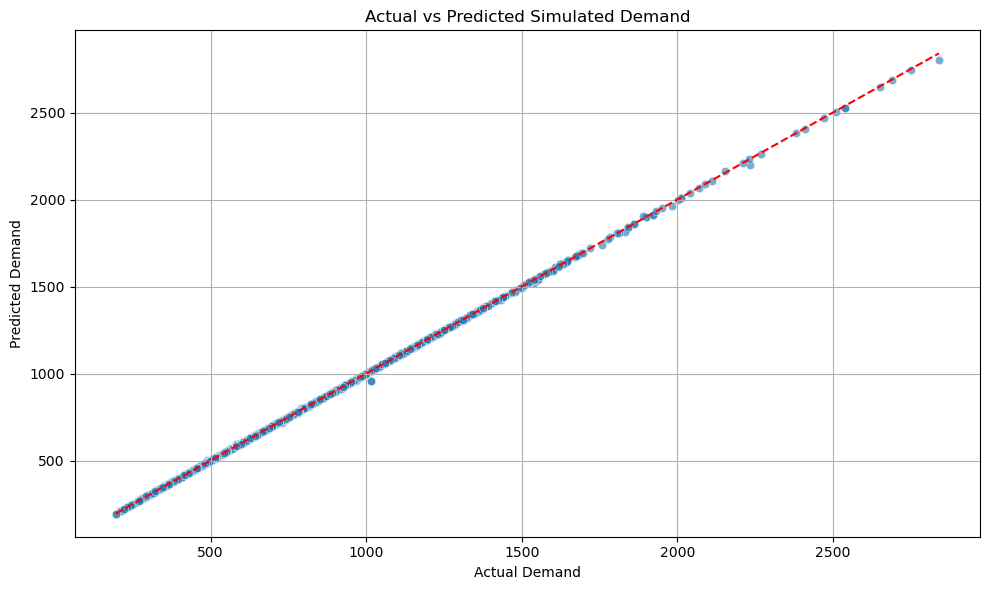

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.title('Actual vs Predicted Simulated Demand')
plt.xlabel('Actual Demand')
plt.ylabel('Predicted Demand')
plt.grid(True)
plt.tight_layout()
plt.show()


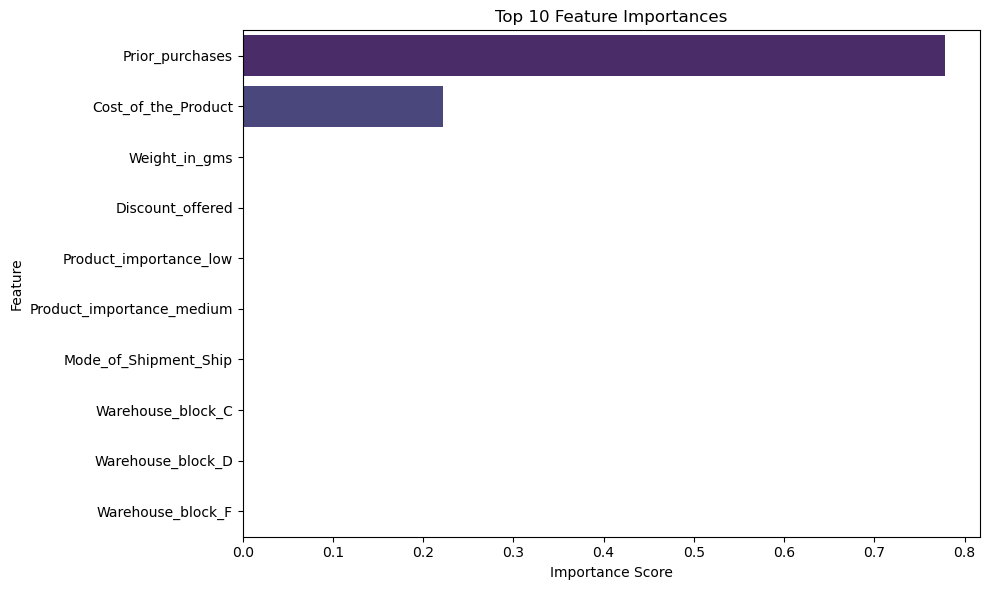

In [43]:
# Extract and sort feature importances
importances = rf_model.feature_importances_
feature_names = X.columns
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# Plot top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df.head(10), x='Importance', y='Feature', palette='viridis')
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
